In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rc('figure', dpi=100)

I computed the forcings using the SAM model, by loading in the initial conditions, and the running 30 minutes forward to compute the tendency. SAM was run with microphysics, radiation, and the boundary layer scheme, so this tendency includes all these effects.

In [25]:
tend_path = "../data/processed/forcings.nc"
input_path = "../data/processed/inputs.nc"

In [26]:
tends = xr.open_dataset(tend_path)
ins = xr.open_dataset(input_path)

tends = tends.assign(p=ins.p).swap_dims({'z': 'p'})
ins = ins.swap_dims({'z': 'p'})

Here are the zonal and time mean forcings computed form SAM

(1000, 10)

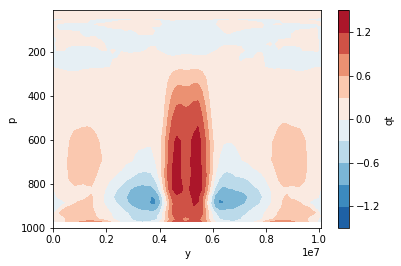

In [37]:
tends.qt.isel(p=slice(3, None)).mean(['time', 'x']).plot.contourf(levels=11)
plt.ylim([1000, 10])

(1000, 10)

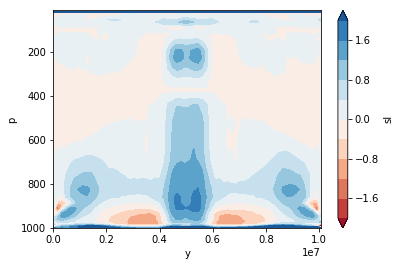

In [36]:
tends.sl.mean(['time', 'x']).plot.contourf(levels=11, vmin=-2, vmax=2, cmap='RdBu')
plt.ylim([1000, 10])

Here is what it looks like for a single point on the equator

(100, 110)

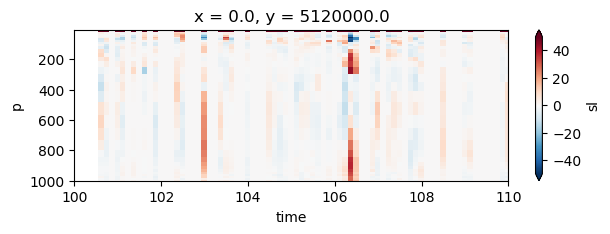

In [55]:
plt.figure(figsize=(7,2))
tends.sl.isel(x=0, y=32).plot(x='time', y='p', cmap='RdBu_r', vmin=-50, vmax=50)
plt.ylim([1000, 5])
plt.xlim([100, 110])

(100, 110)

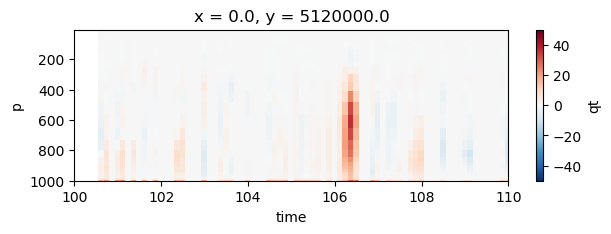

In [58]:
plt.figure(figsize=(7,2))
tends.qt.isel(x=0, y=32).plot(x='time', y='p', cmap='RdBu_r', vmin=-50, vmax=50)
plt.ylim([1000, 5])
plt.xlim([100, 110])